In [1]:
!pip install -q textblob nltk

import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import scipy

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [5]:
from google.colab import files
uploaded = files.upload()

df = pd.read_excel("dataset.xls")
df.dropna(subset=['ticket_text', 'issue_type', 'urgency_level'], inplace=True)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(rf"[{string.punctuation}]", "", text)
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

df['clean_text'] = df['ticket_text'].apply(clean_text)
df.head()

Saving dataset.xls to dataset.xls


,ticket_id,ticket_text,issue_type,urgency_level,product,clean_text
0,1,Payment issue for my SmartWatch V2. I was unde...,Billing Problem,Medium,SmartWatch V2,payment issue smartwatch v underbilled order
2,3,I ordered SoundWave 300 but got EcoBreeze AC i...,Wrong Item,Medium,SoundWave 300,ordered soundwave got ecobreeze ac instead ord...
3,4,Facing installation issue with PhotoSnap Cam. ...,Installation Issue,Low,PhotoSnap Cam,facing installation issue photosnap cam setup ...
5,6,Can you tell me more about the PhotoSnap Cam w...,General Inquiry,Medium,PhotoSnap Cam,tell photosnap cam warranty also available red
6,7,is malfunction. It stopped working after just...,Product Defect,Low,EcoBreeze AC,malfunction stopped working day


In [6]:
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(df['clean_text'])

df['ticket_length'] = df['clean_text'].apply(lambda x: len(x.split()))
df['sentiment'] = df['ticket_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

X_custom = df[['ticket_length', 'sentiment']].values
X_combined = scipy.sparse.hstack([X_tfidf, X_custom])

In [7]:
#issue type
X_train, X_test, y_train, y_test = train_test_split(X_combined, df['issue_type'], test_size=0.2, random_state=42)
model_issue = RandomForestClassifier()
model_issue.fit(X_train, y_train)
print("Issue Type Classification Report:")
print(classification_report(y_test, model_issue.predict(X_test)))

#urgency level
y_urg_train, y_urg_test = train_test_split(df['urgency_level'], test_size=0.2, random_state=42)
model_urgency = RandomForestClassifier()
model_urgency.fit(X_train, y_urg_train)
print("Urgency Level Classification Report:")
print(classification_report(y_urg_test, model_urgency.predict(X_test)))

Issue Type Classification Report:
                    precision    recall  f1-score   support

    Account Access       1.00      1.00      1.00        23
   Billing Problem       1.00      1.00      1.00        19
   General Inquiry       1.00      1.00      1.00        25
Installation Issue       1.00      1.00      1.00        29
     Late Delivery       1.00      1.00      1.00        17
    Product Defect       1.00      1.00      1.00        30
        Wrong Item       1.00      1.00      1.00        23

          accuracy                           1.00       166
         macro avg       1.00      1.00      1.00       166
      weighted avg       1.00      1.00      1.00       166

Urgency Level Classification Report:
              precision    recall  f1-score   support

        High       0.28      0.26      0.27        66
         Low       0.25      0.30      0.27        43
      Medium       0.39      0.37      0.38        57

    accuracy                           0.31     

In [10]:
!pip install dateparser
import dateparser.search

keywords = ['broken', 'delay', 'error', 'late', 'damaged', 'not working']

def extract_entities(text, product_list):
    text_lower = text.lower()
    found_products = [p for p in product_list if str(p).lower() in text_lower]
    dates = dateparser.search.search_dates(text)
    found_keywords = [k for k in keywords if k in text_lower]

    return {
        'products': found_products,
        'dates': [d[0] for d in dates] if dates else [],
        'keywords': found_keywords
    }

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 5.6 MB/s eta 0:00:00


In [11]:
def process_ticket(text):
    cleaned = clean_text(text)
    tfidf = vectorizer.transform([cleaned])
    length = len(cleaned.split())
    sentiment = TextBlob(text).sentiment.polarity
    features = scipy.sparse.hstack([tfidf, [[length, sentiment]]])

    issue_pred = model_issue.predict(features)[0]
    urg_pred = model_urgency.predict(features)[0]
    entities = extract_entities(text, df['product'].dropna().unique())

    return {
        'issue_type': issue_pred,
        'urgency_level': urg_pred,
        'entities': entities
    }

#sample usecase
process_ticket("My laptop is broken and the screen was cracked on 2023-04-18")

{'issue_type': 'General Inquiry',
 'urgency_level': 'High',
 'entities': {'products': [],
  'dates': ['on 2023-04-18'],
  'keywords': ['broken']}}

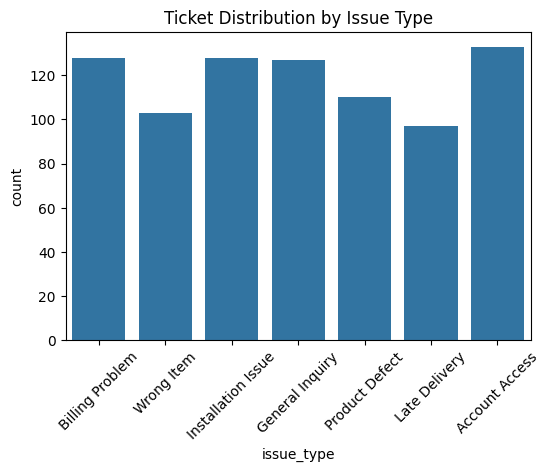

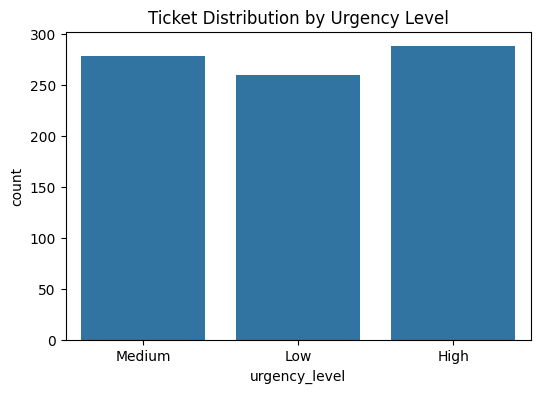

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# issue type distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='issue_type')
plt.title("Ticket Distribution by Issue Type")
plt.xticks(rotation=45)
plt.show()

# urgency level distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='urgency_level')
plt.title("Ticket Distribution by Urgency Level")
plt.show()

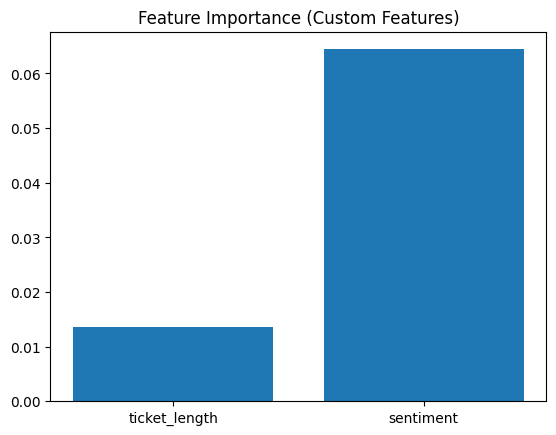

In [13]:
importances = model_issue.feature_importances_[-2:]  # last 2 are ticket's length and sentiment
plt.bar(['ticket_length', 'sentiment'], importances)
plt.title("Feature Importance (Custom Features)")
plt.show()

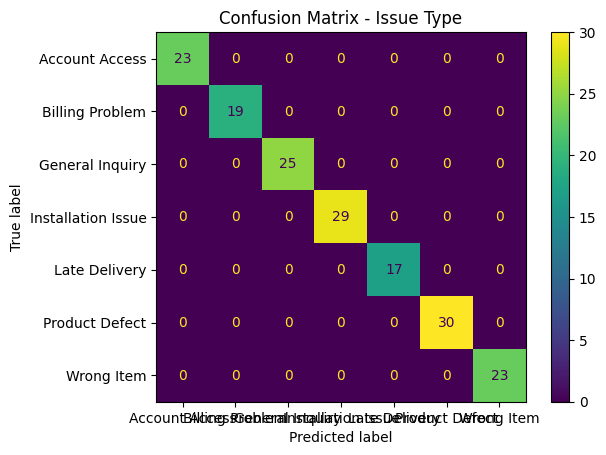

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# for the issue type
y_pred_issue = model_issue.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_issue),
                       display_labels=model_issue.classes_).plot()
plt.title("Confusion Matrix - Issue Type")
plt.show()

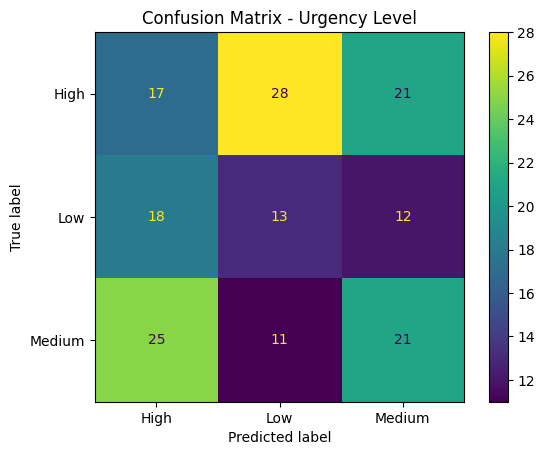

In [19]:
# for the urgency level
y_pred_urgency = model_urgency.predict(X_test)

ConfusionMatrixDisplay(
    confusion_matrix(y_urg_test, y_pred_urgency),
    display_labels=model_urgency.classes_
).plot()

plt.title("Confusion Matrix - Urgency Level")
plt.show()

In [17]:
!pip install gradio
import gradio as gr

def batch_predict(ticket_texts):
    results = []
    for text in ticket_texts.strip().split('\n'):
        if text.strip():
            output = process_ticket(text)
            results.append({ 'input': text, **output })
    return results

gr.Interface(fn=batch_predict, inputs=gr.Textbox(lines=5, placeholder="Paste multiple tickets..."),
             outputs="json", title="Batch Ticket Classifier").launch()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.2 MB/s eta 0:00:00
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b3b02ba742c6838030.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory 

In [20]:
import joblib
import os

os.makedirs('models', exist_ok=True)

joblib.dump(model_issue, 'models/issue_classifier.pkl')
joblib.dump(model_urgency, 'models/urgency_classifier.pkl')
joblib.dump(vectorizer, 'models/tfidf_vectorizer.pkl')

['models/tfidf_vectorizer.pkl']

In [21]:
from google.colab import files
files.download('models/issue_classifier.pkl')
files.download('models/urgency_classifier.pkl')
files.download('models/tfidf_vectorizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>